In [35]:
from qiskit import *
from qiskit.visualization import plot_histogram

## Algorytm Grovera

In [36]:
from qiskit.tools.monitor import job_monitor

from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
def get_quantum_instance(n):

    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')

    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > n and
                                       not x.configuration().simulator and x.status().operational==True))
    print("least busy backend: ", backend)
    return backend

def run_on_machine(circ, backend):
    qc_compiled = transpile(circ, backend, optimization_level=1)
    job = backend.run(qc_compiled, shots=1024)
    job_monitor(job, interval = 1)
    result = job.result()
    return result

In [37]:
backend = get_quantum_instance(2)
backend #ibmq_belem

ibmqfactory.load_account:WARNING:2022-06-04 20:13:27,555: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_belem


<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>

In [39]:
def grover_opt():
    grover_circuit = QuantumCircuit(2)
    grover_circuit.h([0,1])
    grover_circuit.cz(0,1)
    grover_circuit.h([0,1])
    grover_circuit.z([0,1])
    grover_circuit.cz(0,1)
    grover_circuit.h([0,1])
    grover_circuit.measure_all()
    return grover_circuit

qc = grover_opt()

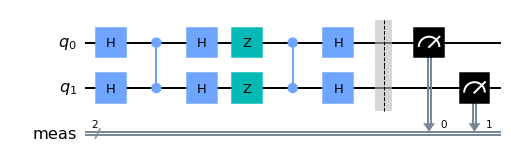

In [40]:
qc.draw('mpl')

{'11': 1024}


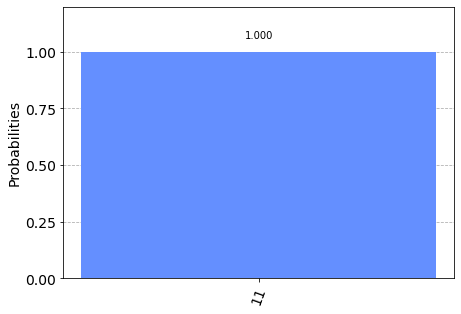

In [41]:
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(qc)
result = aer_sim.run(qobj).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

Job Status: job has successfully run


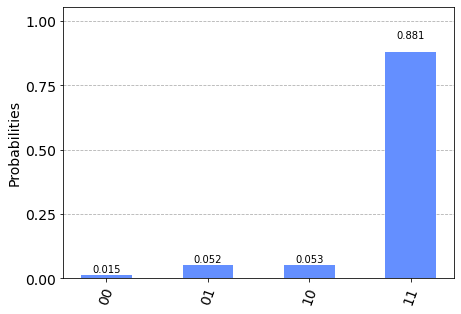

In [42]:
device_result = run_on_machine(qc, backend)
plot_histogram(device_result.get_counts())

## Error Mitigation

In [43]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [44]:
cal_circuits, state_labels = complete_meas_cal(qr=qc.qregs[0], circlabel='measerrormititationcal')

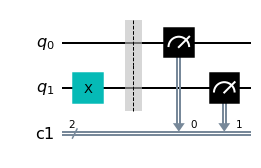

In [45]:
cal_circuits[2].draw('mpl')

In [46]:
len(cal_circuits)

4

In [47]:
cal_job = execute(cal_circuits,
                  backend=backend,
                  shots=1024,
                  optimization_level=0
                  )
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

629ba0ef6d6221755a84b1b1
Job Status: job has successfully run


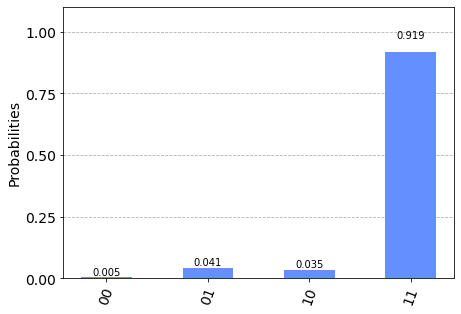

In [48]:
plot_histogram(
    cal_results.get_counts(cal_circuits[3])
)

In [49]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

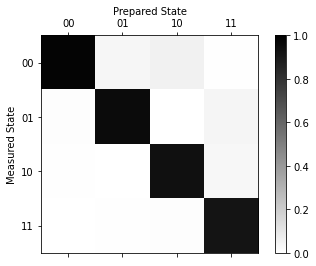

In [50]:
meas_fitter.plot_calibration()

In [51]:
meas_filter = meas_fitter.filter

In [52]:
mitigated_result = meas_filter.apply(device_result)

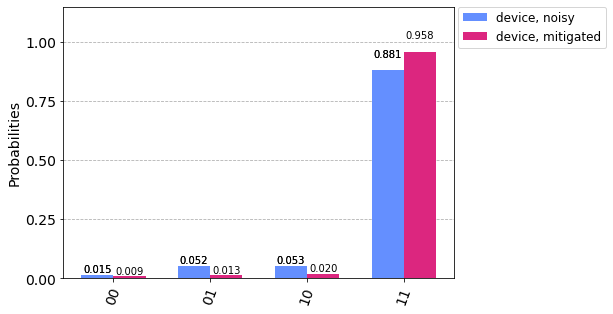

In [53]:
device_counts = device_result.get_counts()
mitigated_counts = mitigated_result.get_counts(qc)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])